## Rapprochement/fusion de bases de données – distance procustéenne / group synchronization / graph matching

In [2]:
from sklearn import datasets
from sklearn import decomposition
from matplotlib import pyplot as plt
from progressbar import progressbar
from scipy.spatial import distance_matrix
from scipy.stats import chi2

import numpy as np,numpy.linalg
import copy
import seaborn as sns; sns.set()
import cvxpy as cp
import scipy
from scipy.spatial import distance

import time
import pprint
import ot
import math
import copy

import pprint


/Users/clementguillo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Cas Gaussien

Comme dans de nombreuses situations, le cas gaussien offre un cadre naturel et facile pour obtenir des résultats de référence d'un point de vue théorique et pratique. Nous avons donc conçu une "configuration gaussienne" pour le problème de la fusion des bases de données. 

Plus tard, nous appliquerons la base de donnée de Médiamétrie à notre problème.

Nous supposons que $A*$ est une matrice aléatoire $n × d$ avec des vecteurs de rangée i.i.d. distribués comme $N (μ, Σ)$ où $\mu ∈ R^d$ est la moyenne inconnue et $Σ ∈ R^{d^2}$ est la matrice de covariance inconnue. 

Nous n'observons pas $A*$ mais seulement une version masquée de celui-ci ; c'est-à-dire que nous observons $A = PA*$ où P est un opérateur de projection révélant certaines entrées spécifiques de $A*$.



On va générer $PA*$ à partir de $A*$.

On considère que $A*$ est notre base de donnée de départ mais inconnue.

On appliquera le cas gaussien à notre problème de panels avec médiamétrie.

On considère que $PA∗$ révèle les premières coordonnées $d_{1}$ des $n_{1}$ premiers vecteurs de ligne de $A∗$, puis les dernières coordonnées  $d_{2}$ des  $n_{2}$ vecteurs de ligne suivants et il révèle toutes les coordonnées des  $n_{3}$ derniers vecteurs de ligne de $A∗$ $(n=n1+n2+n3)$.

In [3]:
def generate_A_star(n,d,mu=None,Sigma=None,create=False):
    """
    Génère une version de A* qui donnera les entrées fixes PA*, (génération aléatoire de mu et sigma)
    
    Input:
    n : nombre de lignes de la matrice A*
    d : nombre de colonnes désirées (nombre de features total, portable et tablette d=d1+d2)
    
    Output:  
    A_star : La matrice A* retournée
    mu : la moyenne du vecteur gaussien générateur
    Sigma : la matrice de variance covariance du vecteur générateur
    """
    if create :
        a = np.random.randint(0,10,size=(d,d)) # génère matrice (d,d) avec nombre entier aléatoire entre [0,10]
        b = (a + a.T)
        _, s, V = np.linalg.svd(b)
        c = np.dot(V.T, np.dot(np.diag(s), V)) # on diagonalise 
        e = (b + c) / 2
        Sigma = (e + e.T) / 2 # avec sigma symétrique définie positive 

        mu = np.random.randint(0,10,size=d)


    #generate A*
    A_star=np.random.multivariate_normal(mu,Sigma,n)

    return A_star, mu, Sigma
    


def build_P_A_star(A,n1,n2,d1):
    """
    Donne la matrice PA* à partir de la matrice A* de dimension nx10
    
    Input:
    n1 : nombre d'individus uniquement présents sur portable
    n2 : nombre d'individus uniquement présent sur tablette
    d1 : nombre features portable
    
    A : Matrice à laquelle on veut appliquer le filtre par blocs P
    
    Output:
    PA_star : la matrice filtrée, avec des 0 là où on ne veut pas voir les données
    """
    PA_star=np.zeros(A.shape)
    PA_star[:n1,:d1]=A[:n1,:d1] #portable
    PA_star[n1:(n1+n2),d1:]=A[n1:(n1+n2),d1:]
    PA_star[(n1+n2):,:]= A[(n1+n2):,:]
    
    return(PA_star)


$Objectifs$ : en utilisant les données $PA*$, nous voulons estimer $A*$. C'est à dire, de trouver un estimateur de $A*$.

Ce problème est une sorte de problème de complétion de matrice mais avec une matrice masquée très structurée et organisée par blocs. Par exemple, disons que nous voulons construire un estimateur $Aˆ*$. 

$Interprétation$ : Les premiers vecteurs de la ligne $n_{1}$ sont les panélistes pour lesquels nous n'observons que les historiques d'url sur les téléphones portables, les vecteurs de la ligne $n_{2}$ suivants sont les panélistes pour lesquels nous n'observons que les historiques d'url sur les tablettes et les derniers $n_{3}$ sont les "bi médias" pour lesquels les deux historiques sont observés. 

En reconstruisant $A*$ à partir de $PA*$, nous complétons en quelque sorte les observations manquantes pour un certain type d'appareil (nous supposons que chaque panéliste devrait avoir les deux historiques).


Quelques estimateurs pour la moyenne conditionnelle : 

Il découle de l'analyse de risque que nous n'avons qu'à estimer les deux moyennes conditionnelles $\mathbb{E}[P_{2}X_{i}|P_{1}X_{i}]$ et $\mathbb{E}[P_{1}X_{i}|P_{2}X_{i}]$

On génère les paramètres de la loi conditionnelle d'une composante de vecteur sachant une autre fixée afin que le vecteur obtenu au final suive une loi normale.

In [4]:
def generate_cond(first,fixed_values,Sigma,mu):
    
    """
    génère les paramètres de la loi conditionnelle d'une composante de vecteur sachant une autre fixée afin que le vecteur
    obtenu au final suive une loi normale
    
    Input:
    
    first : booléen égal à True si on génère les premières composantes, False sinon
    fixed_value : vecteur des valeurs fixées on génère donc len(mu)-len(fixed_values)
    Sigma : Matrice de variance covariance du vecteur gaussien
    mu : espérance duvecteur Gaussien
    
    Output:
    X : le vecteur obtenu
    """
    
    if first:
        d1=len(mu)-len(fixed_values)
        d=len(mu)

        S11=Sigma[:d1,:d1]
        S12=Sigma[:d1,d1:d]
        S22_inv=np.linalg.inv(Sigma[d1:d,d1:d])

        mu_cond=mu[:d1] + np.dot(np.matmul(S12,S22_inv),(fixed_values-mu[d1:d]))
        sigma_cond=S11-np.matmul(np.matmul(S12,S22_inv),S12.T)
    else:
        d1=len(fixed_values)
        d=len(mu)

        S22=Sigma[d1:d,d1:d]
        S12=Sigma[:d1,d1:d]
        S11_inv=np.linalg.inv(Sigma[:d1,:d1])

        mu_cond=mu[d1:d] + np.dot(np.matmul(S12.T,S11_inv),(fixed_values-mu[:d1]))
        sigma_cond=S22-np.matmul(np.matmul(S12.T,S11_inv),S12)
    
    
    return(mu_cond,sigma_cond)

À partir d'une matrice incomplète avec entrée donnée (ici $PA*$), on génère les éléments restants de sorte à ce que la matrice résultante soit issue de la génération de vecteurs gaussiens.
Les données complètes sont la matrice $A*$ et les données observées sont la projection $PA*$. 

Nous pouvons alors construire un algorithme pour ce problème de valeur manquante. 

À la fin de l'algorithme EM, nous obtiendrons un estimateur $\hat{μ}$ de la moyenne et $\hat{Σ}$ de la matrice de covariance. Nous pouvons ensuite compléter les valeurs manquantes soit en prenant une valeur aléatoire selon la densité conditionnelle $f_{P_{2}X|P_{1}X}(\hat{μ},\hat{Σ}))$ ou sa moyenne (donnée ci-dessus) - pour les valeurs de $x = P_{1}X_{1},...,P_{1}X_{n_{1}}$ - et la même chose pour $f_{P_{1}X|P_{2}X}(\hat{μ},\hat{Σ}))$.


In [5]:

def generate_A_star_fixed_PA(PA_star,Sigma,mu,n1,n2,d1):
    """A partir d'une matrice incomplète avec entrée donnée (fixée) génère les éléments restants de sorte 
    à ce que la matrice résultante soit issue de la génération de vecteurs gaussiens mu Sigma
    
    input:
    PA_star = matrice avec les valeurs que l'on veut fixer et des 0 partout ailleurs à compléter
    Sigma = Matrice de variance covariance des vecteurs que l'on veut au final
    mu = Espérance de ce même vecteur
    
    output:
    A_star: la matrice dont les lignes sont issus d'une normale Sigma, mu avec entrées fixées
    
    """
   
    A_star=np.zeros(PA_star.shape)
    
    for l,row in enumerate(PA_star):
        if l<=n1-1:
            m,S=generate_cond(False,row[:d1],Sigma,mu)
            A_star[l]=np.concatenate((row[:d1],np.random.multivariate_normal(m,S)))
            
        if l>n1-1 and l <= n1+n2-1:
            m,S=generate_cond(True,row[d1:],Sigma,mu)
            A_star[l]=np.concatenate((np.random.multivariate_normal(m,S),row[d1:]))
            
        if l>n1+n2-1:
            A_star[l]=row

    return(A_star)
       

## Simulations et tests de fusions de base de données gaussiennes

On effectue ces tests en complétant les lignes incomplète par l'estimateur plug-on de $\mathbb{E}(P_1X|P_2X)$ (resp. $\mathbb{E}(P_2X|P_1X)$

Dans un premier temps on construit les estimateurs de moyenne et de variance empirique sur la base des données présentes dans la matrice incomplète $PA^*$, puis on se sert de ces estimateurs pour donner un estimateur $\hat A^*$ de la matrice complète basé sur les formules de conditionnement d'un vecteur gaussien

In [6]:
def empirical_estimates(n1,n2,n3,d1,d2,PA_star):
    """
    Construit les estimateurs de moyenne et de variance covariance empiriques à partir de la matrice PA*
  
    Input:
    n1,n2,n3 : nombre de panélistes mono et bis
    d1,d2 : nombre de variables portable et tablette
    PA_star : la matrice incomplète
    
    Output:  
    mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat : les estimateurs empiriques
    """
    
    n=n1+n2+n3
    #Calcul des estimateurs à partir de PA_star

    tmp=np.sum(PA_star,axis=0)
    mu1_hat=tmp[:d1]/(n1+n3)
    mu2_hat=tmp[d1:]/(n2+n3)

    v1=np.concatenate((PA_star[:n1,:d1]-mu1_hat,PA_star[n1+n2:,:d1]-mu1_hat),axis=0)
    Sum11=0
    for v in v1:
        Sum11+= np.outer(v,v.T)

    v2=PA_star[n1:,d1:]-mu2_hat
    Sum22=0
    for v in v2:
        Sum22+= np.outer(v,v.T)

   
    v3=PA_star[n1+n2:,:d1]-mu1_hat
    v4=PA_star[n1+n2:,d1:]-mu2_hat
    Sum12=0
    for u,v in zip(v3,v4):
        Sum12+=np.outer(u,v)

    Sigma11_hat=Sum11/(n1+n3)
    Sigma22_hat=Sum22/(n2+n3)
    Sigma12_hat=Sum12/n3
    
    return(mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat)
    
    
    
def build_A_star_hat(mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat,n1,n2,n3,d1,d2,PA_star):
    """
    Construction de la matrice complète à partir d estimateurs de moyenne et de variance
    
    Input:
    n1,n2,n3 : nombre de panélistes mono et bis
    d1,d2 : nombre de variables portable et tablette
    mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat : : les estimateurs de moyenne et de variance
    PA_star : la matrice incomplète
    
    Output:  
    A_star_hat : Estimation de A* à partir des estimateurs fournis
    """
    
    A_star_hat=copy.deepcopy(PA_star)
    d1=len(mu1_hat)
    d2=len(mu2_hat)
    
    for i,Xi in enumerate(PA_star):
        P1Xi=Xi[:d1]
        P2Xi=Xi[d1:]

        mu_P2Xi_P1Xi=mu2_hat+np.matmul(Sigma12_hat.T,np.matmul(np.linalg.inv(Sigma11_hat),(P1Xi-mu1_hat)))
        mu_P1Xi_P2Xi=mu1_hat+np.matmul(Sigma12_hat,np.matmul(np.linalg.inv(Sigma22_hat),(P2Xi-mu2_hat)))

        if i<n1:
            A_star_hat[i]=np.concatenate((P1Xi,mu_P2Xi_P1Xi))
        if i>=n1 and i<n1+n2:
            A_star_hat[i]=np.concatenate((mu_P1Xi_P2Xi,P2Xi))
      
    return(A_star_hat)

## Application

Pour notre exemple, on décide de prendre $n=15$ et $d=6$. Puis $n_{1}=7$, $n_{2}=3$ et $d_{1}=3$ donc $d_{2}=3$.

In [7]:
A_star=generate_A_star(15,6,mu=None,Sigma=None,create=True)[0]
print(A_star)

[[-0.24962712  0.95518811  4.094101    2.98660263  3.72832132  5.08476733]
 [ 5.20163888  7.25002088 12.46434975 11.24675354  3.44550677 10.0929879 ]
 [-2.30745261 -2.36824182  0.43241505 -0.27372672  6.3489894   8.87229559]
 [ 7.2190278  10.39928978 11.75784898 11.43560002  6.76499598  9.41386359]
 [ 0.12090244  0.90103334  6.43393619  5.63502324  3.40440406  7.50873751]
 [ 6.190094    8.71909521  8.86660922  4.69361013  2.96662105 10.01800493]
 [ 4.34762807  6.30954379  7.86335188  5.97415827  5.2786562  10.14586374]
 [ 2.20673906  4.04474224 10.57589519 11.57673781  4.04027878  5.7498405 ]
 [ 3.58054305  5.77398353  8.86753023  5.66920659  0.84613376  5.94460924]
 [ 8.12590661 11.86535176 10.01864357  9.33065694  8.27548523  9.08469701]
 [-6.05463673 -6.96080817  0.181397    0.42802433  3.44488233  4.96139817]
 [ 2.46225756  4.25707651  6.24600855  6.16113289  6.69737568  7.97475688]
 [-3.28828364 -3.62042131  2.77343579  0.99506031  1.57111185  6.4970425 ]
 [ 2.30734278  3.51036873

In [8]:
PA_star=build_P_A_star(A_star,7,3,3)
print(PA_star)

[[-0.24962712  0.95518811  4.094101    0.          0.          0.        ]
 [ 5.20163888  7.25002088 12.46434975  0.          0.          0.        ]
 [-2.30745261 -2.36824182  0.43241505  0.          0.          0.        ]
 [ 7.2190278  10.39928978 11.75784898  0.          0.          0.        ]
 [ 0.12090244  0.90103334  6.43393619  0.          0.          0.        ]
 [ 6.190094    8.71909521  8.86660922  0.          0.          0.        ]
 [ 4.34762807  6.30954379  7.86335188  0.          0.          0.        ]
 [ 0.          0.          0.         11.57673781  4.04027878  5.7498405 ]
 [ 0.          0.          0.          5.66920659  0.84613376  5.94460924]
 [ 0.          0.          0.          9.33065694  8.27548523  9.08469701]
 [-6.05463673 -6.96080817  0.181397    0.42802433  3.44488233  4.96139817]
 [ 2.46225756  4.25707651  6.24600855  6.16113289  6.69737568  7.97475688]
 [-3.28828364 -3.62042131  2.77343579  0.99506031  1.57111185  6.4970425 ]
 [ 2.30734278  3.51036873

In [9]:
Sigma=generate_A_star(15,6,mu=None,Sigma=None,create=True)[2]
print(Sigma)

[[18.11161885  8.34591138 11.19333306  6.95411706  9.13002042  8.38779377]
 [ 8.34591138  9.45326028  9.09128283 11.49657919  9.92841177  6.10810875]
 [11.19333306  9.09128283 10.692813    9.33655321 11.67993485  8.10000648]
 [ 6.95411706 11.49657919  9.33655321 15.52750343 10.41654709  5.50953754]
 [ 9.13002042  9.92841177 11.67993485 10.41654709 14.47249407  9.19201547]
 [ 8.38779377  6.10810875  8.10000648  5.50953754  9.19201547  6.5564521 ]]


In [11]:
mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat=empirical_estimates(7,3,5,3,3,PA_star)
A_star_hat=build_A_star_hat(mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat,7,3,5,3,3,PA_star)


In [12]:
print(A_star_hat)

[[-0.24962712  0.95518811  4.094101    2.45042955  6.45213029  6.18581452]
 [ 5.20163888  7.25002088 12.46434975 10.28989097  2.08533028  8.34781929]
 [-2.30745261 -2.36824182  0.43241505  3.17258327  3.47319956  6.33586456]
 [ 7.2190278  10.39928978 11.75784898  9.61754157  7.99884859  8.86227906]
 [ 0.12090244  0.90103334  6.43393619  5.04210641  2.11519181  6.56128748]
 [ 6.190094    8.71909521  8.86660922  9.95427597  7.2929425   9.09257579]
 [ 4.34762807  6.30954379  7.86335188  8.58118805  5.74863198  8.39292881]
 [ 3.69814365  5.62086514  8.16309107 11.57673781  4.04027878  5.7498405 ]
 [-2.20478772 -2.48977628  5.95460333  5.66920659  0.84613376  5.94460924]
 [ 7.75814357 11.08900566  9.993711    9.33065694  8.27548523  9.08469701]
 [-6.05463673 -6.96080817  0.181397    0.42802433  3.44488233  4.96139817]
 [ 2.46225756  4.25707651  6.24600855  6.16113289  6.69737568  7.97475688]
 [-3.28828364 -3.62042131  2.77343579  0.99506031  1.57111185  6.4970425 ]
 [ 2.30734278  3.51036873

## Analyse de l'erreur entre $A*$ et son estimateur $\hat A^*$ 

Dans la première fonction, on fixe la matrice $PA^*$ une fois pour toute et on génère des matrices $A^*$ dont les lignes sont des vecteurs gaussiens $\mathcal{N}(\mu,\sigma)$ mais dont la partie $PA^*$ est la même. Et on calcule l'erreur moyenne observée sur les $n_1$ lignes des panélistes "portable", dans la seconde on réitère le processus de génération à chaque fois et on calcule l'erreur moyenne.

In [7]:
def return_mat_err_cond(n1,n2,n3,d1,d2,mu,Sigma,ngen=3000):
    """
    Calcul de l'erreur d'estimation conditionnellement aux entrées PA_star fixée
    
    Input:
    n1,n2,n3 : nombre de panélistes mono et bis
    d1,d2 : nombre de variables portable et tablette
    mu, Sigma : moyenne et matrice de variance des lignes générées
    ngen : nombre de simulations
    
    Output:  
    mat_err : liste de taille ngen contenant la moyenne de l'erreur commise sur les lignes de panélistes "portable" pour chaque 
    génération (avec PA_star fixée)
    """
    n=n1+n2+n3
    A_star, mu , Sigma=generate_A_star(n,(d1+d2), mu , Sigma)#

    PA_star=build_P_A_star(A_star,n1,n2,d1)
    
    mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat=empirical_estimates(n1,n2,n3,d1,d2,PA_star)
    A_star_hat=build_A_star_hat(mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat,n1,n2,n3,d1,d2,PA_star)

    mat_err=[]
    for g in progressbar(range(ngen)):
        Ag=generate_A_star_fixed_PA(PA_star,Sigma,mu,n1,n2,d1)
        mat_err.append((Ag[:n1]-A_star_hat[:n1])**2)
    return(mat_err)

def return_mat_err(n1,n2,n3,d1,d2,mu,Sigma,ngen=3000):
    """
    Calcul de l'erreur d'estimation conditionnellement aux entrées PA_star fixée
    
    Input:
    n1,n2,n3 : nombre de panélistes mono et bis
    d1,d2 : nombre de variables portable et tablette
    mu, Sigma : moyenne et matrice de variance des lignes générées
    ngen : nombre de simulations
    
    Output:  
    mat_err : liste de taille ngen contenant la moyenne de l'erreur commise sur les lignes de panélistes "portable" pour chaque 
    génération 
    """
    n=n1+n2+n3
    A_star, mu , Sigma=generate_A_star(n,(d1+d2), mu , Sigma)
    
    mat_err=[]
    for g in progressbar(range(ngen)):
        A_star, mu , Sigma=generate_A_star(n,(d1+d2), mu , Sigma)#
        PA_star=build_P_A_star(A_star,n1,n2,d1)
        
        mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat=empirical_estimates(n1,n2,n3,d1,d2,PA_star)
        A_star_hat=build_A_star_hat(mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat,n1,n2,n3,d1,d2,PA_star)

        mat_err.append((Ag[:n1]-A_star_hat[:n1])**2)
    return(mat_err)

L'erreur moyenne observée sur l'enselmble des générations devrait être distribuées comme une gaussienne

100% (1000 of 1000) |####################| Elapsed Time: 0:01:07 Time:  0:01:07


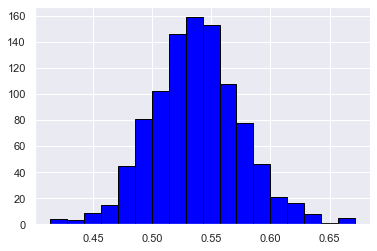

In [16]:
np.random.seed(1234)
#Test avec valeurs arbitraires
n1=200
n2=200
n3=30

d1=2
d2=2

mu= list(np.zeros(4)) # si Sigma et mu sont mises à none elles sont générées aléatoirement
Sigma= np.eye(4)

list_materr = return_mat_err_cond(n1,n2,n3,d1,d2,mu,Sigma,ngen=1000)

#on devrait observer une gaussienne
plt.hist([np.mean(v) for  v in list_materr], color = 'blue', edgecolor = 'black',bins = int(180/10))
plt.show()


### Vitesse de convergence selon taille du problème

On voudrait savoir ici le nombre de génération nécessaire pour que l'erreur empirique moyenne converge vers son espérance.
Pour, on fixe $n_1 =n_2=n_3$, $d_1=d_2$,  $\mu$ à 0 et $\Sigma = \mathbf{I}$ et en faisant varier $n_1$ et $d_2$.
Je regarde au bout de combien de temps l'erreur empirique moyenne des $||A_g-A^*||_2$ semble converger.


In [18]:
#vitesse de convergence en fonction du nombre de panélistes
d=4 
mu= np.zeros(d+d) 
Sigma= np.eye(d+d)
liste_n=[30,500,1000]
list_vconvergence_n=[]
for i,n in enumerate(liste_n):

    list_materr = return_mat_err_cond(n,n,n,d,d,mu,Sigma,ngen=1000)
    vconvergence=[np.mean(list_materr[:n]) for n in range(len(list_materr))]
    list_vconvergence_n.append(vconvergence)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:10 Time:  0:00:10
100% (1000 of 1000) |####################| Elapsed Time: 0:02:42 Time:  0:02:42
100% (1000 of 1000) |####################| Elapsed Time: 0:05:24 Time:  0:05:24


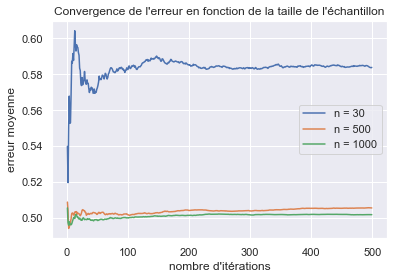

In [69]:
np.save("list_vconvergence_n.npy",list_vconvergence_n)
#list_vconvergence_n=np.load("list_vconvergence_n.npy")

plt.title("Convergence de l'erreur en fonction de la taille de l'échantillon")
a,=plt.plot(list_vconvergence_n[0][:500],label='n = 30')
b,=plt.plot(list_vconvergence_n[1][:500],label='n = 500')
c,=plt.plot(list_vconvergence_n[2][:500],label='n = 1000')

plt.xlabel("nombre d'itérations")
plt.ylabel("erreur moyenne")
plt.legend(handles=[a,b,c])
plt.show()

np.save("list_vconvergence_d.npy",list_vconvergence_d)


In [43]:
#Vitesse de convergence en fonction du nombre de variables
n=100
liste_d=[4,10,100]
list_vconvergence_d=[]
for i,d in enumerate(liste_d):
    mu= np.zeros(d+d) 
    Sigma= np.eye(d+d)
    list_materr = return_mat_err(n,n,n,d,d,mu,Sigma,ngen=1000)
    vconvergence=[np.mean(list_materr[:n]) for n in range(len(list_materr))]
    list_vconvergence_d.append(vconvergence)


100% (1000 of 1000) |####################| Elapsed Time: 0:00:33 Time:  0:00:33
100% (1000 of 1000) |####################| Elapsed Time: 0:00:36 Time:  0:00:36
100% (1000 of 1000) |####################| Elapsed Time: 0:03:24 Time:  0:03:24


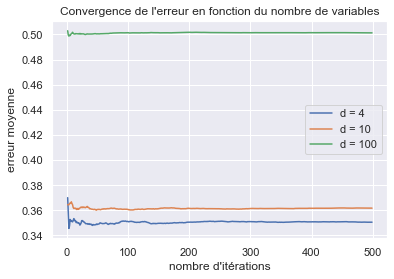

In [64]:
np.save("list_vconvergence_d.npy",list_vconvergence_d)
#list_vconvergence_n=np.load("list_v_convergence_n.npy")

plt.title("Convergence de l'erreur en fonction du nombre de variables")
d,=plt.plot(list_vconvergence_d[0][:500],label='d = 4')
e,=plt.plot(list_vconvergence_d[1][:500],label='d = 10')
f,=plt.plot(list_vconvergence_d[2][:500],label='d = 100')

plt.xlabel("nombre d'itérations")
plt.ylabel("erreur moyenne")
plt.legend(handles=[d,e,f])
plt.show()

Au bout de 200 itérations on aura une idée suffisamment précise de la quantité $\mathbb{E}(||\hat A- A^*||^2)$ 

### Influence de la matrice de corrélation sur l'erreur

On veut observer ici l'effet sur l'estimation de la corrélation entre les variables, on pose donc $d_1 = d_2 =1$ et on fait varier le paramètre $\sigma$ dans la matrice de variance covariance $\begin{pmatrix} 1 & \sigma \\
\sigma & 1
\end{pmatrix}$

In [34]:
n1=200
n2=200
d1=1
d2=1
mu=np.zeros(d1+d2)
vec_err=[]
for i in range(10):
    Sigma=np.array([[1,i/10],[i/10,1]])
    materr5 = return_mat_err_cond(n1,n1,int(n1/2),1,1,mu,Sigma,ngen=400)
    vec_err.append(np.mean([np.mean(v) for v in materr5]))
     

100% (400 of 400) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
100% (400 of 400) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
100% (400 of 400) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
100% (400 of 400) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
100% (400 of 400) |######################| Elapsed Time: 0:00:27 Time:  0:00:27
100% (400 of 400) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
100% (400 of 400) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
100% (400 of 400) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
100% (400 of 400) |######################| Elapsed Time: 0:00:27 Time:  0:00:27
100% (400 of 400) |######################| Elapsed Time: 0:00:28 Time:  0:00:28


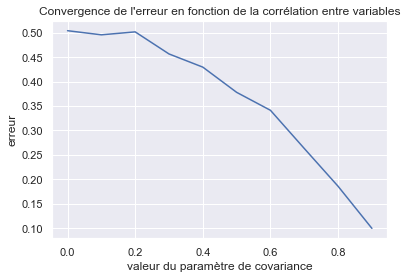

In [38]:
plt.plot(np.arange(10)/10,vec_err)
plt.title("Convergence de l'erreur en fonction de la corrélation entre variables")
plt.xlabel("valeur du paramètre de covariance")
plt.ylabel("erreur")
plt.show()


Sur ce petit problème, l'erreur commise semble diminuer à mesure que le paramètre de corrélation augmente.
On veut maintenant mesurer l'erreur commise sur un problème à taille réelle avec les matrices de variance covariance de la forme $$\Sigma = \begin{pmatrix}
I_{d_1} & \sigma J_{d_1,d_2} \\
\sigma J_{d_2,d_1} & I_{d_2}
\end{pmatrix}$$

In [20]:
n1=500
n2=500
d1=20
d2=20
mu=np.zeros(d1+d2)
vec_err2=[]
for sigma in np.linspace(0,1/np.sqrt(d1*d2),10):
    
    Sigma=np.block([
         [np.eye(d1),sigma*np.ones((d1,d2))],
         [sigma*np.ones((d2,d1)), np.eye(d2)]
    ])
    materr5 = return_mat_err_cond(n1,n1,int(n1/2),1,1,mu,Sigma,ngen=100)
    vec_err2.append(np.mean([np.mean(v) for v in materr5]))

100% (100 of 100) |######################| Elapsed Time: 0:00:23 Time:  0:00:23
100% (100 of 100) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
100% (100 of 100) |######################| Elapsed Time: 0:00:30 Time:  0:00:30
100% (100 of 100) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
100% (100 of 100) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
100% (100 of 100) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
100% (100 of 100) |######################| Elapsed Time: 0:00:31 Time:  0:00:31
100% (100 of 100) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
100% (100 of 100) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
100% (100 of 100) |######################| Elapsed Time: 0:00:27 Time:  0:00:27


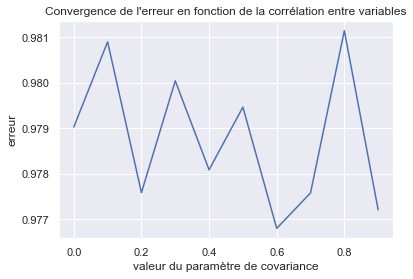

In [22]:

plt.plot(np.arange(10)/10,vec_err2)
plt.title("Convergence de l'erreur en fonction de la corrélation entre variables")
plt.xlabel("valeur du paramètre de covariance")
plt.ylabel("erreur")
plt.show()


 Ici l'effet du paramètre $\sigma$ sur l'erreur est ambigu.

### Influence du nombre de panélistes sur l'erreur

On veut mesurer ici l'influence du nombre de panélistes sur l'erreur commise, on fixe le nombre de panélistes monos et on augmente progressivement le nombre de bis

In [26]:
d1,d2=1,1
mu=np.zeros(d1+d2)
Sigma=np.array([[1,0.9],[0.9, 1]])
n1=100
n2=100
list_n3=[5,10,25,50,100,300]
list_err=[]
for n3 in list_n3:
    materr = return_mat_err_cond(n1,n2,n3,1,1,mu,Sigma,ngen=1000)
    list_err.append(np.mean([np.mean(v) for v in materr]))


100% (1000 of 1000) |####################| Elapsed Time: 0:00:31 Time:  0:00:31
100% (1000 of 1000) |####################| Elapsed Time: 0:00:31 Time:  0:00:31
100% (1000 of 1000) |####################| Elapsed Time: 0:00:31 Time:  0:00:31
100% (1000 of 1000) |####################| Elapsed Time: 0:00:31 Time:  0:00:31
100% (1000 of 1000) |####################| Elapsed Time: 0:00:30 Time:  0:00:30
100% (1000 of 1000) |####################| Elapsed Time: 0:00:31 Time:  0:00:31


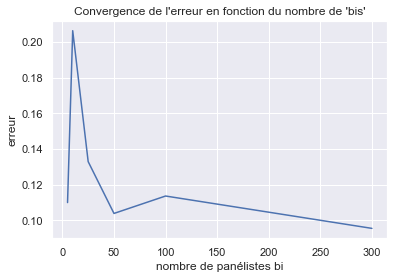

In [27]:
plt.plot(list_n3,list_err)
plt.title("Convergence de l'erreur en fonction du nombre de 'bis'")
plt.xlabel("nombre de panélistes bi")
plt.ylabel("erreur")
plt.show()

On veut voir ici l'effet d'une augmentation $n_1$, $n_2$ du nombre de panélistes monos sur l'erreur commise

In [94]:
n3=100
d1=1
d2=1
list_n1=[10,50,100,250,500,1000]
list_n2=[10,50,100,250,500,1000]
mu=np.zeros(d1+d2)

Sigma=np.array([[1,4/5],[4/5,1]])

list_mat_err=np.zeros((len(list_n1),len(list_n2)))
for i,n1 in enumerate(list_n1):
    for j,n2 in enumerate(list_n2):           
        materr = return_mat_err_cond(n1,n2,n3,1,1,mu,Sigma,ngen=1000)
        list_mat_err[i,j]=np.mean([np.mean(v) for v in materr])


100% (1000 of 1000) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1000 of 1000) |####################| Elapsed Time: 0:00:09 Time:  0:00:09
100% (1000 of 1000) |####################| Elapsed Time: 0:00:17 Time:  0:00:17
100% (1000 of 1000) |####################| Elapsed Time: 0:00:41 Time:  0:00:41
100% (1000 of 1000) |####################| Elapsed Time: 0:01:20 Time:  0:01:20
100% (1000 of 1000) |####################| Elapsed Time: 0:02:40 Time:  0:02:40
100% (1000 of 1000) |####################| Elapsed Time: 0:00:10 Time:  0:00:10
100% (1000 of 1000) |####################| Elapsed Time: 0:00:16 Time:  0:00:16
100% (1000 of 1000) |####################| Elapsed Time: 0:00:25 Time:  0:00:25
100% (1000 of 1000) |####################| Elapsed Time: 0:00:48 Time:  0:00:48
100% (1000 of 1000) |####################| Elapsed Time: 0:01:26 Time:  0:01:26
100% (1000 of 1000) |####################| Elapsed Time: 0:02:44 Time:  0:02:44
100% (1000 of 1000) |###################

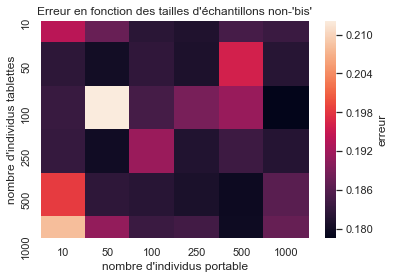

In [407]:
#np.save("list_mat_err_heatmap_n1_n2.py",list_mat_err)
list_mat_err=np.load("list_mat_err_heatmap_n1_n2.py.npy")
list_n1=[10,50,100,250,500,1000]
list_n2=[10,50,100,250,500,1000]
xticklabels=list_n1
yticklabels=list_n2
ax = sns.heatmap(list_mat_err,cbar_kws={'label': 'erreur'},xticklabels=xticklabels,yticklabels=yticklabels) 
plt.title("Erreur en fonction des tailles d'échantillons non-'bis'")
plt.xlabel("nombre d'individus portable")
plt.ylabel("nombre d'individus tablettes")
plt.show()

### Décomposition de l'erreur

Pour bien comprendre ce qu'il e passe au niveau de l'erreur dans le cas gaussien.
On va fixer $n_3$, et $n_2$ et reproduire le processus pour des tailles $n_1$ de panélistes portable croissante.
On va décomposer l'erreur en 2 parties une part due à l'aléa ie la différence entre $P_1X$ et son espérance théorique $\mathbb{E}(P_1X|P_2X)$ et l'autre part due à l'erreur d'approximation la différence entre $\hat \mu$ et et l'espérance théorique. On s'attend en théorie à ce que l'erreur due à l'aléa augmente avec $n_1$ et que l'autre partie diminue. Selon les résultats obtenus dans les heatmap, en moyenne l'augmentation de l'erreur moyenne due à l'aléa devrait prendre le pas sur la diminution de l'erreur moyenne due à l'augmentation de la taille de l'échantillon

In [8]:
def return_errors(n1,n2,n3,d1,d2,mu,Sigma):
    """
    Calcul des deux types d'erreur
    
    Input:
    n1,n2,n3 : nombre de panélistes mono et bis
    d1,d2 : nombre de variables portable et tablette
    mu, Sigma : moyenne et matrice de variance des lignes générées
    
    Output:  
    tableau avec l'erreur moyenne liée à l'aléa et l'erreur moyenne liée à l'estimation
    """
    n=n1+n2+n3
    A_star,mu,Sigma=generate_A_star(n,(d1+d2),mu,Sigma)
    PA_star=build_P_A_star(A_star,n1,n2,d1)
   
    #Calcul des estimateurs à partir de PA_star

    mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat = empirical_estimates(n1,n2,n3,d1,d2,PA_star)
    
    mean_esti=0
    mean_alea=0

    for i,Xi in enumerate(A_star):
        if(i<n1):
            #Sur la première partie de la base on a accès à P1Xi seulement on veut connaitre P2Xi
            P1Xi=Xi[:d1]
            P2Xi=Xi[d1:] 

            #mu théorique
            mu_theorique_P2Xi_P1Xi=mu[d1:]+np.matmul(Sigma[d1:,:d1],np.matmul(np.linalg.inv(Sigma[:d1,:d1]),(P1Xi-mu[:d1])))

            #mu empirique
            mu_P2Xi_P1Xi=mu2_hat+np.matmul(Sigma12_hat.T,np.matmul(np.linalg.inv(Sigma11_hat),(P1Xi-mu1_hat)))
           
            mean_esti+=np.linalg.norm(mu_theorique_P2Xi_P1Xi-mu_P2Xi_P1Xi)
            mean_alea+=np.linalg.norm(P2Xi-mu_P2Xi_P1Xi)
    
    return(np.array([mean_alea/n1,mean_esti/n1]))

In [32]:
ngen=700
courbes_erreurs=np.zeros((10,2))
for j,n in enumerate((np.arange(10)+1)*10):
    array_error=np.zeros((ngen,2))
    for gen in progressbar(range(ngen)):
        array_error[gen]=return_errors(n,n,n,d1,d2,mu,Sigma)
    courbes_erreurs[j]=np.sum(array_error,axis=0)

100% (700 of 700) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (700 of 700) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (700 of 700) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (700 of 700) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (700 of 700) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (700 of 700) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (700 of 700) |######################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (700 of 700) |######################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (700 of 700) |######################| Elapsed Time: 0:00:04 Time:  0:00:04
100% (700 of 700) |######################| Elapsed Time: 0:00:04 Time:  0:00:04


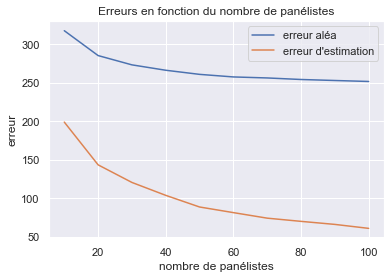

In [35]:
a,= plt.plot((np.arange(10)+1)*10,courbes_erreurs[:,0],label="erreur aléa")
b,= plt.plot((np.arange(10)+1)*10,courbes_erreurs[:,1],label="erreur d'estimation")
plt.title("Erreurs en fonction du nombre de panélistes")
plt.ylabel("erreur")
plt.xlabel("nombre de panélistes")
plt.legend(handles=[a,b])
plt.show()


### Génération des données

Pour toute la suite on évaluera les algorithmes à partir de données générées à partir d'une matrice de variance covariance simplifiée de la forme $$\Sigma = \begin{pmatrix}
I_{d_1} & \sigma J_{d_1,d_2} \\
\sigma J_{d_2,d_1} & I_{d_2}
\end{pmatrix}$$ et une moyenne $\mu$ nulle


In [9]:
def generate_data(d1,d2,n1,n2,n3,mu,sigma):
    """
    Génération de données avec une matrice de variance covariance simplifiée
    
    Input:
    n1,n2,n3 : nombre de panélistes mono et bis
    d1,d2 : nombre de variables portable et tablette
    mu : moyenne et matrice de variance des lignes générées
    sigma : paramètre sigma de la matrice de variance covariance simplifiée
    
    Output:  
    A_star, PA_star : matrice complète et matrice masquée générée à partir des vecteurs gaussiens (mu,Sigma)
    mu, Sigma : paramètres ayant servis à générer A_star et  PA_star
    """
    n=n1+n2+n3
    mu=np.zeros(d1+d2)+mu
    mu1=mu[:d1]
    mu2=mu[d1:]
     

    Sigma=np.block([
         [np.eye(d1),sigma*np.ones((d1,d2))],
         [sigma*np.ones((d2,d1)), np.eye(d2)]
    ])

    A_star,_,_=generate_A_star(n,(d1+d2), mu , Sigma)#
    PA_star=build_P_A_star(A_star,n1,n2,d1)#n_1,n_2,d_1 #matrice avec le masque qu'on va fixer
    
    return (A_star, PA_star, mu, Sigma)

### Intervalles de confiance

Je vérifie ici dans le cas où $\Sigma$ connu que l'estimateur plug-in $\hat mu_{P1X_i}$ tombe bien dans l'intervalle de confiance théorique (à 95 %) calculable 
à l'aide $\tilde \Sigma = \frac{1}{n_2+n_3}I_{d_2}+\frac{n_2-n_3}{(n_2+n_3)(n_1+n_3)}\sigma^2 d_1 J_{d_2,d_2}$

Il nous faut faire ceci en plusieurs étapes : 

1) je génère la matrice de données ce qui me permet d'avoir les estimateurs empiriques et je me concentre sur la première ligne de la matrice résultante 

2) je calcule les bornes d'IC 95% (avec Sigma connu) et je regarde combien de fois on tombe à l'intérieur 


In [39]:
#A matrice Sigma connue d'abord
list_chi=[]
d1=50
d2=50
n1=2000
n2=2000
n3=2000

for it in progressbar(range(2000)):
   
    A_star, PA_star, mu, Sigma = generate_data(d1,d2,n1,n2,n3,6,0.01)
    P1Xi = PA_star[0][:d1]
    S11_inv = np.linalg.inv(Sigma[:d1,:d1])
    S21 = Sigma[:d1,d1:].T
    S22 = Sigma[d1:,d1:]

    #calcul de l'espérance conditionnelle théorique (inconnue en théorie)
    mu_cond = mu[d1:] + np.dot(np.matmul(S21,S11_inv),(P1Xi-mu[:d1]))

    #calcul de l'espérance conditionnelle estimée (on connait Sigma ici mais pas mu qu'on estime)
    tmp = np.sum(PA_star,axis=0)
    mu1_hat = tmp[:d1]/(n1+n3)
    mu2_hat = tmp[d1:]/(n2+n3)

    mu_cond_hat = mu2_hat + np.dot(np.matmul(S21,S11_inv),(P1Xi-mu1_hat))

    #Calcul de $\tilde \Sigma$
    Sigma_tilde = S22/(n2+n3) + np.matmul(np.matmul(S21,S11_inv),S21.T)*(n2-n3)/((n1+n3)*(n2+n3))

    #j'ai une statistique du khi2 dont je calcule le quantile à 95 %
    chi = np.dot(np.dot(mu_cond_hat-mu_cond,np.linalg.inv(Sigma_tilde)),mu_cond_hat-mu_cond)
    #Inverse fonction de survie =S=1-F donc on prend l'inverse 0.05 pour avoir le quantile à 95 %

    list_chi.append(chi)

quant=chi2.isf(0.05, d2, loc=0, scale=1)



100% (2000 of 2000) |####################| Elapsed Time: 0:00:44 Time:  0:00:44


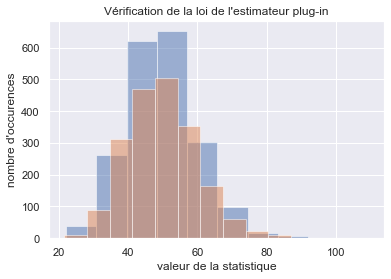

In [40]:
#np.sum(list_chi<=quant)/len(list_chi) #-> on a bien 95 % dans l'intervalle de confiance
r = chi2.rvs(d2, size=2000,loc=0,scale=1)
plt.hist(list_chi, alpha=0.5, label="distribution empirique")
plt.hist(r,alpha=0.5,label="distribution théorique")
plt.title("Vérification de la loi de l'estimateur plug-in")
plt.ylabel("nombre d'occurences")
plt.xlabel("valeur de la statistique")
plt.show()


# Recherche du maximum de vraisemblance

Ici on veut estimer les entrées manquantes de $PA^*$ avec un estimateur de type plug-in calculé sur la base des estimateurs du maximum de vraisemblance. 

## Maximum de vraisemblance cas simplifié

Après avoir simplifié la paramétrisation du problème, en particulier en introduisant une matrice de variance-covariance plus simple de la forme : $$\Sigma = \begin{pmatrix}
I_{d_1} & \sigma J_{d_1,d_2} \\
\sigma J_{d_2,d_1} & I_{d_2}
\end{pmatrix}$$

On obtient des équations vérifiées par l'estimateur du maximum de vraisemblance de $\mu$, $\Sigma$ Les équations obtenues sont : 


\begin{equation*}
    \begin{pmatrix}
    u \\
    v
    \end{pmatrix} = A \begin{pmatrix}
    \mu_1\\
    \mu_2
    \end{pmatrix}
\end{equation*}

avec $$u=-\sum_{i \in I_1} P_1X_i - \frac{\sigma^2 d_2}{1-\sigma^2 d_1 d_2}J_{d_1,d_1}\sum_{i=n_1+n_2}^nP_1X_i + \frac{\sigma}{1-\sigma^2 d_1 d_2}J_{d_1,d_2}\sum_{i=n_1 +n_2}^n P_2X_i $$, $$v=-\sum_{i \in I_2} P_2X_i - \frac{\sigma^2 d_1}{1-\sigma^2 d_1 d_2}J_{d_2,d_2}\sum_{i=n_1+n_2}^n P_2X_i + \frac{\sigma}{1-\sigma^2 d_1 d_2}J_{d_2,d_1}\sum_{i=n_1 +n_2}^n P_1X_i $$

et $$A = \begin{pmatrix} -(n_1+n_3)I_1+\frac{\sigma^2 d_2 n_3}{1-\sigma^2 d_2 d_1} J_{d_1,d_1} & \frac{\sigma n_3 }{1-\sigma^2 d_1 d_2}J_{d_1,d_2} \\
  \frac{\sigma n_3 }{1-\sigma^2 d_1 d_2}J_{d_2,d_1} & -(n_2+n_3)I_2+\frac{\sigma^2 d_1 n_3}{1-\sigma^2 d_2 d_1} J_{d_2,d_2}
\end{pmatrix}$$

En $\sigma$ :
\begin{equation*}
    \begin{split}
        0=&\sigma^3[-n_3(d_1d_2)^2]+ \sigma^2[d_1d_2\sum_{i=n_1+n_2}^n(P_1X_i-\mu_1)^TJ_{d_1,d_2}(P_2X_i-\mu_2)]\\
        +& \sigma [-\sum_{i=n_1+n_2}^n d_2 \langle P_1X_i-\mu_1,\mathbf{1} \rangle^2-\sum_{i=n_1+n_2}^n d_1 \langle P_2X_i-\mu_2,\mathbf{1} \rangle^2 + d_1d_2n_3]+ \sum_{i=n_1+n_2}^n(P_1X_i-\mu_1)^TJ_{d_1,d_2}(P_2X_i-\mu_2)
    \end{split}
\end{equation*}


On se propose de résoudre ces équations algorithmiquement : on recherche ici les 0 d'une fonction $(\mu,\sigma) \mapsto F(\mu,\sigma)$ avec $F=\begin{pmatrix}
F_{\mu} \\
F_{\sigma}
\end{pmatrix}$ 


### Algorithme de Newton

En premier lieu on essaie un algorithme de type Newton alterné pour les retrouver (ce qui correspond à une descente de gradient) :

- On initialise $\mu_0$, $\sigma_0$ et opn définit $\eta_{\mu}$, $\eta_{\sigma}$:
- à l'étape t on calcule $\mu_{t+1}=\mu_{t}-\eta_{\mu}F_{\mu}(\mu_t,\sigma_t)$ et  $\sigma_{t+1}=\sigma_{t}-\eta_{\sigma}F_{\sigma}(\mu_{t+1},\sigma_t)$

Pour garder une matrice de variance covariance positive, on projette les valeurs obtenues sur $\sigma$ sur la contrainte $0\leq \sigma \leq \frac{1}{\sqrt{d_1d_2}}$

In [10]:
def F_mu(mu,sigma):
    """
    Calcul de F_mu en fonction de la valeur des paramètres en t
    
    Input:
    
    mu : estimation de la moyenne 
    sigma : estimation du paramètre sigma à l'itération courante
    
    Output:  
    f_mu : composante en mu de la fonction F
    """
    mu1=mu[:d1]
    mu2=mu[d1:]
    
    u=(-np.sum(np.concatenate((PA_star[:n1,:d1],PA_star[(n1+n2):,:d1])),axis=0)-((sigma**2)*d2/(1-(sigma**2)*d1*d2))* np.matmul(np.ones((d1,d1)),np.sum(PA_star[(n1+n2):,:d1],axis=0))+(sigma/(1-(sigma**2)*d1*d2))*np.matmul(np.ones((d1,d2)),np.sum(PA_star[(n1+n2):,d1:],axis=0)))
    v=(-np.sum(PA_star[n1:,d1:],axis=0)-((sigma**2)*d1/(1-(sigma**2)*d1*d2))* np.matmul(np.ones((d2,d2)),np.sum(PA_star[(n1+n2):,d1:],axis=0))+(sigma/(1-(sigma**2)*d1*d2))*np.matmul(np.ones((d2,d1)),np.sum(PA_star[(n1+n2):,:d1],axis=0)))

    A11=(-(n1+n3)*np.eye(d1)+((sigma**2)*d2*n3/(1-(sigma**2)*d2*d1)))*np.ones((d1,d1))
    A22=(-(n2+n3)*np.eye(d2)+((sigma**2)*d1*n3/(1-(sigma**2)*d2*d1)))*np.ones((d2,d2))
    A12=(sigma*n3/(1-(sigma**2)*d2*d1))*np.ones((d1,d2))
    A=np.block([
         [A11,A12],
         [A12.T,A22]
    ])
    
    f_mu=np.dot(A,mu)-np.concatenate((u,v))
    
    return f_mu

def F_sigma(mu,sigma):
    """
    Calcul de F_sigma en fonction de la valeur des paramètres en t
    
    Input:
    
    mu : estimation de la moyenne 
    sigma : estimation du paramètre sigma à l'itération courante
    
    Output:  
    f_sigma : composante en sigma  de la fonction F
    """


    mu1=mu[:d1]
    mu2=mu[d1:]
    
    f_sigma=((sigma**3)\
    +(sigma**2)*(1/-n3*(d1*d2))*(np.trace(np.matmul(np.matmul(PA_star[(n1+n2):,:d1]-mu1,np.ones((d1,d2))),(PA_star[(n1+n2):,d1:]-mu2).T)))\
    +sigma*(1/-n3*d2*(d1)**2)*((-1)*np.sum(np.matmul((PA_star[(n1+n2):,:d1]-mu1),np.ones(d1))**2,axis=0)-d1*np.sum(np.matmul((PA_star[(n1+n2):,d1:]-mu2),np.ones(d2))**2,axis=0)+d1*d2*n3)\
    +((1/-n3*(d1*d2)**2))*np.trace(np.matmul(np.matmul(PA_star[(n1+n2):,:d1]-mu1,np.ones((d1,d2))),(PA_star[(n1+n2):,d1:]-mu2).T)) \
    )
    
    return(f_sigma)

def Newton(mu,sigma,pas_mu,pas_sigma):
    """
    Une itération de l'algorithme de Newton
    Input:
    
    mu : estimation de la moyenne à l'itération courante
    sigma : estimation du paramètre sigma à l'itération courante
    
    Output:  
    mu, sigma : les itérations suivantes des paramètres à estimer
    """
    mu=mu-pas_mu*F_mu(mu,sigma)
    sigma=sigma-pas_sigma*F_sigma(mu,sigma)
    
    return (mu,sigma)
    

### Test de l'algorithme de Newton

In [47]:
# je lance l'algorithme de newton
mut=np.zeros(d1+d2)+3
sigmat=0.007
niter=30
for i in range(niter):
    mut,sigmat=Newton(mut,sigmat,0.03,0.001)
    if(sigmat>1/np.sqrt(d1*d2)):
        sigmat=1/np.sqrt(d1*d2)
        mut=F_mu(mut,sigmat)
    if(sigmat<0):
        sigmat=0
        mut=F_mu(mut,sigmat)
    print(sigmat)


/Users/clementguillo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
/Users/clementguillo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in add
  app.launch_new_instance()
/Users/clementguillo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/Users/clementguillo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in add
/Users/clementguillo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/clementguillo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/clementguillo/opt/anaconda3/lib/python3.7/site-packages/ipyke

0.02
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


On observe une divergence numérique assez rapide ici. L'algorithme est assez instable ce qui est sûrement dû au fait que les coefficients du polynôme en sigma sont très grands on opte sur une méthode de résolution récursive plus bas

### Tentative avec résolution du polynome


- On initialise $\mu_0$, $\sigma_0$ et opn définit $\eta_{\mu}$, $\eta_{\sigma}$:
- à l'étape t on trouve $\sigma_{t+1}$ tel que $F_{\sigma}(\mu_t,\sigma_{t+1})=0$ et  $\mu_{t+1}$ tel que $F_{\sigma}(\mu_{t+1},\sigma_{t+1})=0$

In [11]:

def roots_sigma(mu):
    """
    Calcul des racines de F_sigma en sigma et à mu fixé
    On ne retient que les racines rélles >0 et < 1/sqrt(d1d2) pour que la matrice sigma reste définie positive
    
    Input:
    
    mu : estimation de la moyenne 
    sigma : estimation du paramètre sigma à l'itération courante
    
    Output:  
    f_sigma : composante en sigma  de la fonction F
    """


    borne=1/(np.sqrt(d1*d2))
    mu1=mu[:d1]
    mu2=mu[d1:]

    a = (-n3*(d1*d2)**2)
    b = (d1*d2*np.trace(np.matmul(np.matmul(PA_star[(n1+n2):,:d1]-mu1,np.ones((d1,d2))),(PA_star[(n1+n2):,d1:]-mu2).T)))
    c = (-d2*np.sum(np.matmul((PA_star[(n1+n2):,:d1]-mu1),np.ones(d1))**2,axis=0)-d1*np.sum(np.matmul((PA_star[(n1+n2):,d1:]-mu2),np.ones(d2))**2,axis=0)+d1*d2*n3)
    d = np.trace(np.matmul(np.matmul(PA_star[(n1+n2):,:d1]-mu1,np.ones((d1,d2))),(PA_star[(n1+n2):,d1:]-mu2).T)) 

    p = np.poly1d([a, b, c, d])
    #print(np.poly1d(p))
    rac=p.r[numpy.isreal(p.r)]
    rac1=rac[rac <= borne]
    if len(rac1)==0:
        return(borne)
    if  len(rac1[rac1 > 0])==0:
        return(0)
    
    return np.float(rac1[rac1 > 0][0]) #Rajouter une condition sur sigma  plus petit que 1/sqrt(d1d2)

def solve_mu(sigma):
    
    u=(1/n)*(-np.sum(np.concatenate((PA_star[:n1,:d1],PA_star[(n1+n2):,:d1])),axis=0)-((sigma**2)*d2/(1-(sigma**2)*d1*d2))* np.matmul(np.ones((d1,d1)),np.sum(PA_star[(n1+n2):,:d1],axis=0))+(sigma/(1-(sigma**2)*d1*d2))*np.matmul(np.ones((d1,d2)),np.sum(PA_star[(n1+n2):,d1:],axis=0)))
    v=(1/n)*(-np.sum(PA_star[n1:,d1:],axis=0)-((sigma**2)*d1/(1-(sigma**2)*d1*d2))* np.matmul(np.ones((d2,d2)),np.sum(PA_star[(n1+n2):,d1:],axis=0))+(sigma/(1-(sigma**2)*d1*d2))*np.matmul(np.ones((d2,d1)),np.sum(PA_star[(n1+n2):,:d1],axis=0)))

    A11=(-(n1+n3)*np.eye(d1)+((sigma**2)*d2*n3/(1-(sigma**2)*d2*d1)))*np.ones((d1,d1))
    A22=(-(n2+n3)*np.eye(d2)+((sigma**2)*d1*n3/(1-(sigma**2)*d2*d1)))*np.ones((d2,d2))
    A12=(sigma*n3/(1-(sigma**2)*d2*d1))*np.ones((d1,d2))
    A=(1/n)*np.block([
         [A11,A12],
         [A12.T,A22]
    ])
    
    return np.linalg.solve(A,np.concatenate((u,v)))   


100% (300 of 300) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


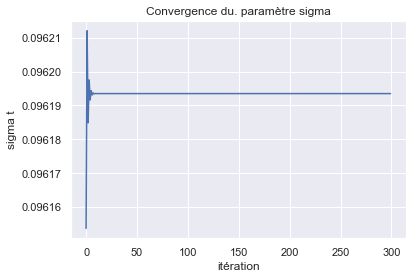

In [181]:
niter,d1,d2,n1,n2,n3,mu,sigma = 300,10,10,400,400,50,2,0.09
n=n1+n2+n3
A_star, PA_star, mu, Sigma = generate_data(d1,d2,n1,n2,n3,mu,sigma)


sigmat=0
mut=np.zeros(d1+d2)+5

list_sigmat=[]

for i in progressbar(range(niter)):
    sigmat=roots_sigma(mut)
    list_sigmat.append(sigmat)
    mut=solve_mu(sigmat)
   
    
plt.plot(list_sigmat)
plt.title("Convergence du. paramètre sigma")
plt.ylabel("sigma t")
plt.xlabel("itération")
plt.show()



In [12]:
def build_A_star_hat_EMV(PA_star):
    """
    Complétion de la matrice PA_star à partir des estimateurs du maximum de vraisemblance obtenu
    Input:
    
    PA_star : la matrice à compléter
    
    Output:  
    A_star_hat_EMV : Matrice complétée avec l'estimateurplug-in basé sur les estimations du MV
    """
    #Initialisation
    sigmat=2
    mut=np.zeros(d1+d2)+5

    for i in range(niter):
        sigmat=roots_sigma(mut)
        mut=solve_mu(sigmat)
        
    mu1=mut[:d1]
    mu2=mut[d1:]
    
    #Reconstruction de Sigma

    Sigma_EMV=np.block([
         [np.eye(d1),sigmat*np.ones((d1,d2))],
         [sigmat*np.ones((d2,d1)), np.eye(d2)]
    ])

    #Et on reconstruit A_star
    A_star_hat_EMV=build_A_star_hat(mut[:d1],mut[d1:],Sigma_EMV[:d1,:d1],Sigma_EMV[:d1,:d1],Sigma_EMV[:d1,:d1],n1,n2,n3,d1,d2,PA_star)
    return A_star_hat_EMV

## Recherche du maximum de vraisemblance via l'algorithme EM

Dans le cadre Gaussien, en supposant la matrice de variance covariance connue, on obtient les équations récursives suivantes sur les paramètres de moyenne via l'algorithme EM utilisé en présence de valeurs manquantes.

\begin{equation*}
    \begin{split}
        n[(\Sigma^{-1})_{1,1} \mu_1 + (\Sigma^{-1})_{1,2} \mu_2] &=a\\
        n[(\Sigma^{-1})_{2,2} \mu_2 + (\Sigma^{-1})_{2,1} \mu_1] &=b
    \end{split}
\end{equation*}


ie $$\begin{pmatrix} 
\mu_1 \\
\mu_2
\end{pmatrix} =\frac{1}{n}\Sigma \begin{pmatrix} 
a \\
b
\end{pmatrix} $$

$$a= \sum_{i\in I_1}(\Sigma^{-1})_{1,1}(P_1X_i)+ \sum_{i \in I_2}(\Sigma^{-1})_{1,2}(P_2X_i)+\sum_{i=1}^{n_1}(\Sigma^{-1})_{1,2}\tilde \mu_{i2}^{old}+\sum_{i=n_1+1}^{n_1+n_2}(\Sigma^{-1})_{1,1}\tilde \mu_{i1}^{old}$$
$$b=\sum_{i\in I_2}(\Sigma^{-1})_{2,2}(P_2X_i)+ \sum_{i \in I_1}(\Sigma^{-1})_{2,1}(P_1X_i)+\sum_{i=n_1+1}^{n_1+n_2}(\Sigma^{-1})_{2,1}\tilde \mu_{i1}^{old}+\sum_{i=1}^{n_1}(\Sigma^{-1})_{2,2}\tilde \mu_{i2}^{old}$$

$$\tilde \mu_1^{old}=\mu_1^{old}+ (\Sigma_{2,1}^{old})^T(\Sigma_{2,2}^{old})^{-1}(P_2X_i-\mu_2^{old})$$
$$\tilde \mu_2^{old}=\mu_2^{old}+ (\Sigma_{1,2}^{old})^T(\Sigma_{1,1}^{old})^{-1}(P_1X_i-\mu_1^{old})$$


On trouve les paramètres $\mu_1$ et $\mu_2$ qui nous servirons de base pour la prochaine itération de l'algorithme qui convergera vers l'estimateur du maximum de vraisemblance. Dans la fonction suivante on effectue donc une itération de l'algorithme EM, le paramètre $\mu$ étant défini par le résultat de l'itération précédente.

In [13]:
def EM(mu,Sigma):
    """
    Calcul d'une itération de l'algorithme EM 
    Input:
    mu: itération courante des paramètres du modèle
    Sigma: matrice de variance-covariance du modèle 
    
    Output:  
    itération suivante de l'EM pour mu
    """
  
    mu1=mu[:d1]
    mu2=mu[d1:]

    Sigma_inv=np.linalg.inv(Sigma)

    mu2_old=mu2+(np.matmul(np.matmul(Sigma[:d1,d1:].T,np.linalg.inv(Sigma[:d1,:d1])),(PA_star[:,:d1]-mu1).T)).T
    mu1_old=mu1+(np.matmul(np.matmul(Sigma[d1:,:d1].T,np.linalg.inv(Sigma[d1:,d1:])),(PA_star[:,d1:]-mu2).T)).T

    a=np.matmul(Sigma_inv[:d1,:d1],np.sum(np.concatenate((PA_star[:n1,:d1],PA_star[(n1+n2):,:d1])),axis=0)) \
    + np.matmul(Sigma_inv[:d1,d1:],np.sum(PA_star[n1:,d1:],axis=0)) \
    + np.matmul(Sigma_inv[:d1,d1:],np.sum(mu2_old[:n1,:],axis=0))   \
    + np.matmul(Sigma_inv[:d1,:d1],np.sum(mu1_old[n1:(n1+n2),:],axis=0))

    b=np.matmul(Sigma_inv[d1:,d1:],np.sum(PA_star[n1:,d1:],axis=0)) \
    + np.matmul(Sigma_inv[d1:,:d1],np.sum(np.concatenate((PA_star[:n1,:d1],PA_star[(n1+n2):,:d1])),axis=0)) \
    + np.matmul(Sigma_inv[d1:,:d1],np.sum(mu1_old[n1:(n1+n2),:],axis=0))   \
    + np.matmul(Sigma_inv[d1:,d1:],np.sum(mu2_old[:n1,:],axis=0))

    return (1/n)*np.matmul(Sigma,np.concatenate((a,b)))

### Test de l'algorithme EM

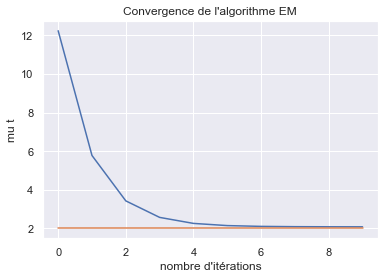

In [58]:
#test
niter,d1,d2,n1,n2,n3,mu,sigma = 3000,10,10,100,100,50,2,0.009
n=n1+n2+n3
A_star, PA_star, mu, Sigma = generate_data(d1,d2,n1,n2,n3,mu,sigma)

#Lancement de l'algorithme
mut=np.zeros(d1+d2)+30

list_mut=[]
for i in range(niter):
    mut=EM(mut,Sigma)
    list_mut.append(mut)

A_star_hat_EM1=build_A_star_hat(mut[:d1],mut[d1:],Sigma[:d1,:d1],Sigma[:d1,:d1],Sigma[:d1,:d1],n1,n2,n3,d1,d2,PA_star)

plt.title("Convergence de l'algorithme EM")
plt.xlabel("nombre d'itérations")
plt.ylabel("mu t")
plt.plot(np.array(list_mut)[:10,0])
plt.plot(np.repeat(mu[0],10))
plt.show()

### Estimation de $\hat A^*$ via l'algorithme EM

Plutôt que de supposer $\Sigma$ connu on va l'estimer à l'aide des données $PA^*$, puis on appliquera l'algorithme EM en supposant que $\hat \Sigma$ estime correctement $\Sigma$

In [14]:
def build_A_star_hat_EM(PA_star):
    """
    Complète les valeurs de la matrice incomplète via les estimazteurs plug-in obtenus en utilisant l'algorithme EM
    Input:
    PA_star : la matrice à compléter
    
    Output:  
    A_star_hat_EM : la matrice complétée
    """
    mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat=empirical_estimates(n1,n2,n3,d1,d2,PA_star)
    Sigma_emp=np.block([
         [Sigma11_hat,Sigma12_hat],
         [Sigma12_hat.T, Sigma22_hat]
    ])
    mut=np.zeros(d1+d2)+30

    for i in range(niter):
        mut=EM(mut,Sigma_emp) 

    A_star_hat_EM=build_A_star_hat(mut[:d1],mut[d1:],Sigma_emp[:d1,:d1],Sigma_emp[:d1,:d1],Sigma_emp[:d1,:d1],n1,n2,n3,d1,d2,PA_star)
    return(A_star_hat_EM)


# Modèle de Poisson Multinomial

On considère les ligne de $A^*$ sont des vecteurs aléatoires $X_i=(X^1,..,X^d)$ générés par le processus de suivant : on génère de manière indépendante $Y^i \sim \mathcal{P}(\theta_i), i = 0,..,d$.
Et on pose $X^i = Y^i + Y^0$ de telle sorte que $cov(X^i,X^j)=Var(Y^0)=\theta_0$. Ce modèle nous permet de contrôler la corrélation entre nos variables.\\


En posant $p=(\theta_0,..,\theta_p)$. La forme générale de la vraisemblance est la suivante :

$$P(X_i,p)=P(X_i^1=x_i^1,..,X_i^d=x_i^d)=\exp(-\sum_{i=1}^d \theta_i)\prod_{j=1}^d\frac{\theta_i^{x^j_i}}{x^j_i!}\sum_{u=0}^{s_i}\prod_{j=1}^d C_{x^j_i}^u(u!)^{d-1}\left(\frac{\theta_0}{\prod_{i=1}^d\theta_i}\right)^u$$


## Algorithme EM dans le cas de données complètes

Ici on veut appliquer l'algortithme EM pour estimer les paramètres d'un modèle de Poisson multinomial sur données simulées :

Les équations récursives obtenues sont les suivantes :

\begin{equation*}
    \begin{split}
        \theta_0^{(k+1)}&= \frac{1}{n}\sum_{i=1}^n E[Y_i^0|X,\theta^{(k)}]\\
        \theta_j^{(k+1)}&=\frac{1}{n}\sum_{i=1}x_i^j-\theta_0^{(k)}\\
    \end{split}
\end{equation*}

Pour chaque ligne $X_i=(x_{i1},..x_{id})$ de la matrice (complète), on pose $s_i = \min_j(x_{i,j})$ et il faut donc  calculer :
\begin{equation*}
    \begin{split}
        \mathbb{E}(Y_{i}^0|X_i,\theta)=\sum_{k=0}^{s_i} kP(Y_{i}^0=k|X_i,\theta)
    \end{split}{}
\end{equation*}

Avec :
$$\displaystyle P(Y_{i}^0=k|X_i,\theta)=\frac{\displaystyle \frac{\theta_0^k}{k!}\prod_{j=1}^d\frac{\theta_j^{-k}}{(x_i^j-k)!}     } {\displaystyle \sum_{u=0}^{s_i} \frac{\theta_0^u}{u!}\prod_{j=1}^d \frac{\theta_j^{-u}}{(x_i^j-u)!} }$$

Le calcul de ces quantités nécessite une attention particulière dans la mesure où si on les calcule directement un problème d'underflow survient. Pour le gérer on procède de la sorte :

- on pose $\alpha_k=\frac{\theta_0^k}{k!}\prod_{j=1}^d\frac{\theta_j^{-k}}{(x_i^j-k)!}$ 
- on calcule le vecteur $(\log(\alpha_1),..,\log(\alpha_{s_i}))$
- on obtient $\log(\alpha_{max})=\max_j \log(\alpha_j)$ et on construit :
$(\log(\frac{\alpha_1}{\alpha_{max}}),..,\log(\frac{\alpha_{s_i}}{\alpha_{max}}))$
- L'underflow étant évité par la précédente normalisation, on peut enfin passer à l'exponentielle chacune des composantes du vecteur et construire la probabilité souhaitée

In [15]:
# Génération de données complètes
def generate_A_star_poisson(d,n,theta_0):
    """
    Génère des données A_star suivant un modèle de Poisson multinomial  
    
    Input:
    d,n : nombre de colonnes et nombre de lignes de la base
    theta_0 : le paramètre de moyenne de la variable latente Y^0 jamais observée
    
    Output:  
    A_star : la matrice générée
    """
    theta_is=np.arange(d)+1
    A_star=np.zeros([n,d])
    
    for i,theta_i in enumerate(theta_is):
            A_star[:,i]=np.random.poisson(theta_i,n)
    for i,l in enumerate(A_star): # Même génération pour toute la ligne
           A_star[i]+=np.random.poisson(theta_0)
    
    return A_star

        
def iteration_EM_Poisson(theta_0_t,theta_is_t,A_star):
    """
    Une itération de l'algorithme EM sur des données complètes
    
    Input:
    d,n : nombre de colonnes et nombre de lignes de la base
    theta_0 : le paramètre de moyenne de la variable latente Y^0 jamais observée
    theta_is : liste des paramètres de moyenne des Y_i
    A_star : La matrice de donnée
    
    Output:  
    theta_O_t2, theta_is_t2 : les paramètres du modèles estimés à l'itération suivante"""
    list_esp=[]
    A_star_copy=copy.deepcopy(A_star)
    A_star_copy=np.round(A_star_copy)
    A_star_copy[A_star_copy<0]=0
    for X in A_star_copy:

        list_log=[]
        s_i=np.int(np.min(X))
        if s_i==0:
            list_esp.append(0)
        else:    
            
            for k in (np.arange(s_i)+1):
                list_log.append(k*np.log(theta_0_t)-np.log(np.float(math.factorial(k))) + np.sum([-k*np.log(theta_is_t[i])-np.log(np.float(math.factorial(xij-k))) for i,xij in enumerate(X)]))

            #ok j'identifie le max et je normalise pour éviter l'overflow
            log_alpha_max = np.max(list_log)
            list_alpha_norm = np.exp(list_log-log_alpha_max)
            list_prob_cond=list_alpha_norm/np.sum(list_alpha_norm)
            esp=np.sum((np.arange(s_i)+1)*list_prob_cond)
            list_esp.append(esp)

    theta_0_t2=np.mean(list_esp)
    theta_is_t2=np.mean(A_star,axis=0)-theta_0_t
    theta_is_t2[theta_is_t2<0]=0
    return(theta_0_t2,theta_is_t2)




### Test de l'algorithme EM sur modèle de Poisson multinomial

In [133]:
#Lancement de l'algorithme EM
np.random.seed(1234)

d,n = 6,1500
A_star=generate_A_star_poisson(d,n,5)

n_iter=70

#Initialisation
theta_0_t=np.min(np.mean(A_star,axis=0))-2
theta_is_t=np.ones(d)

list_theta_0=[]
for i in progressbar(range(n_iter)):
    #print(theta_0_t)
    theta_0_t, theta_is_t=iteration_EM_Poisson(theta_0_t,theta_is_t,A_star)
    list_theta_0.append(theta_0_t)


100% (70 of 70) |########################| Elapsed Time: 0:00:32 Time:  0:00:32


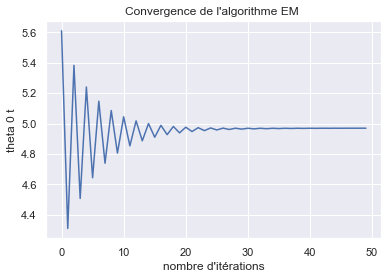

In [134]:
plt.plot(list_theta_0[:50])
plt.title("Convergence de l'algorithme EM ")
plt.xlabel("nombre d'itérations")
plt.ylabel("theta 0 t")
plt.show()

## Estimation des paramètres sur données incomplètes via l'algorithme EM
il n'est cependant pas possible de prolonger la logique de l'algorithme sur des données incomplètes puisque les équations obtenues pour les espérances conditionnelles $\mathbb{E}(P_1X|P_2X)$ ne donnent pas de formes suffisamment simples. Cependant on peut s'inspirer du travail sur données complètes pour proposer une méthode d'estimation :


- On estime l'EMV $\hat \theta_0$ sur la base de données des "bis" et on calcule les composantes respectives de $\hat \theta_{is}$ sur les individus "monos"+"bis".
- Pour chaque ligne i de la matrice incomplète, on calcule $s_i = \min_{1\leq i \leq d_1} x_i^j$ et on calcule pour $0\leq k \leq s_i$, les $P(Y_{i}^0=k|X_i,\theta)$
-  On maximise cette dernière quantité en $k$ pour obtenir $Y_i^0max$ et on complète les $x_i^j$, $1\leq j \leq d_2$ manquants par $Y_i^0max+\theta_j$.



In [16]:
def build_A_star_hat_poisson(P_A_star):
    """
    Complète les valeurs de la matrice incomplète via les estimateurs 
    obtenus avec les équations EM du modèle de Poisson
    
    Input:
    PA_star : la matrice à compléter
    
    Output:  
    A_star_hat : la matrice complétée
    """
    #Calcul de l'EMV
    n_iter=50
    
    #J'isole les bases monos et les bases "bis"
    A_star_I1_I3=np.concatenate((PA_star[:n1,:d1],PA_star[(n1+n2):,:d1]))
    A_star_I2_I3=PA_star[n1:,d1:]
    A_star_I3=PA_star[(n1+n2):,:]
    
    #Initialisation des paramètres
    d=d1+d2
    theta_0_t=np.min(np.mean(A_star,axis=0))-2
    theta_is_t=np.ones(d)

    for i in progressbar(range(n_iter)):
        _, theta_is_1=iteration_EM_Poisson(theta_0_t,theta_is_t[:d1],A_star_I1_I3)
        _, theta_is_2=iteration_EM_Poisson(theta_0_t,theta_is_t[d1:],A_star_I2_I3)
        theta_0_3, _=iteration_EM_Poisson(theta_0_t,theta_is_t,A_star_I3)

        theta_is_t=np.concatenate((theta_is_1,theta_is_2))
        theta_0_t=(theta_0_3)       
    
    theta_0=theta_0_t
    theta_is=theta_is_t
    
    #remplissage de la matrice  
    A_star_hat=copy.deepcopy(PA_star)
    A_star_copy=copy.deepcopy(PA_star)
    A_star_copy=np.round(A_star_copy)
    A_star_copy[A_star_copy<0]=0
    for l,X in enumerate(A_star_copy):
            list_log=[]
            
            if(l<n1):
                s_i=np.int(np.min(X[:d1]))
                if s_i==0:
                    Y0max=0
                else:    
                    for k in (np.arange(s_i)+1):
                        list_log.append(k*np.log(theta_0)-np.log(np.float(math.factorial(k))) + np.sum([-k*np.log(theta_is[i])-np.log(np.float(math.factorial(xij-k))) for i,xij in enumerate(X[:d1])]))
                    Y0max = np.argmax(list_log)
                A_star_hat[l]=np.concatenate((PA_star[l,:d1],Y0max+theta_is[d1:]))
                
            if(n1<=l and l<n1+n2):
                s_i=np.int(np.min(X[d1:]))
                if s_i==0:
                    Y0max=0
                else:    
                    for k in (np.arange(s_i)+1):
                        list_log.append(k*np.log(theta_0)-np.log(np.float(math.factorial(k))) + np.sum([-k*np.log(theta_is[i])-np.log(np.float(math.factorial(xij-k))) for i,xij in enumerate(X[d1:])]))
                    Y0max = np.argmax(list_log)
                A_star_hat[l]=np.concatenate((Y0max+theta_is[:d1],PA_star[l,d1:]))
              
    return(A_star_hat)

In [151]:
d1,d2,n1,n2,n3 =  3,3,200,200,200
d=d1+d2
n=n1+n2+n3
A_star=generate_A_star_poisson(d,n,10)
PA_star=build_P_A_star(A_star,n1,n2,d1)

build_A_star_hat_poisson(PA_star)

100% (50 of 50) |########################| Elapsed Time: 0:00:22 Time:  0:00:22


array([[10.        , 10.        , 10.        , 11.58138032, 12.69138032,
        13.57888032],
       [10.        , 10.        , 16.        , 12.58138032, 13.69138032,
        14.57888032],
       [ 8.        ,  8.        , 10.        , 10.58138032, 11.69138032,
        12.57888032],
       ...,
       [ 9.        , 10.        , 10.        , 11.        , 17.        ,
        15.        ],
       [12.        , 10.        , 14.        , 13.        , 12.        ,
        22.        ],
       [16.        , 16.        , 20.        , 21.        , 22.        ,
        23.        ]])

# Analyse procrustéenne

On reproduit ici la méthode de complétion proposée par médiamétrie, en plusieurs étapes :

- On réalise une analyse factorielle sur les $n_1+n_3$ individus présentant des informations sur la base portable et de même pour les $n_2+n_3$ sur tablette. On récupère les 20 premiers axes et on se concentre sur les nuages de points associés au plan factoriel engendré par les 20 premiers axes de l'AXP.

- On ne se concentre ensuite plus que sur les individus "bis" qui ont alors une représentation dans le nuage de point tablette et une autre dans le nuage de point portable. 

- On réalise un matching en cherchant une transformation linéaire entre ces deux nuages de point $X$ et $Y$ qui permettra de minimiser la fonction objectif :

$$R^*=\underset{R \in \mathcal{O}_n}{argmin\|XR - Y\|_F^2}$$

La solution à ce problème est donné par la décomposition en valeurs singulières $U^TSV$ de la matrice $X^TY$ et $R^*=U^TV$

- On applique enfin cette transformation aux individus non-bis du nuage "portable" pour transporter ces derniers dans l'espace du nage "tablette", puis on trouve un donneur par plus proche voisin afin de compléter les données manquantes 

## Construction des nuages de points avec une Kernel PCA

En plus de l'analyse en composantes principales classiques on se propose de tester aussi l'analyse en composante principale à noyau :
- La Kernel PCA utilise le "Kernel trick" pour permettre de transporter les variables de départ x dans un espace de features inconnu $x \mapsto \phi(x)$ : 
- Je prends un kernel Gaussien en paramètrisant par $sigma$ et el que pour deux vecteurs : $$K(x,y)=e^{-\frac{||x-y||^2}{\sigma^2}}$$
- $\tilde K = K-\frac{1}{N}\mathbf{1}^TK-K\frac{1}{N}\mathbf{1}+\frac{1}{N^2}\mathbf{1}^TK\mathbf{1}$ avec le vecteur de taille $N$ rempli de 1.
- $y_k(x) = \phi(x)^Tv_k = \sum_{i=1}^N a_{ki}\tilde K(x,x_i)$

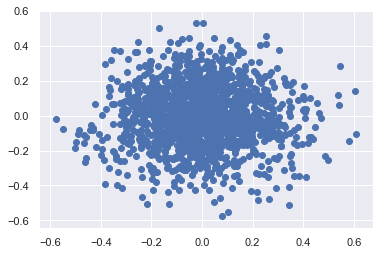

In [68]:
niter,d1,d2,n1,n2,n3,mu,sigma = 300,100,100,1000,1000,500,6,0.009
n=n1+n2+n3
A_star, PA_star, mu, Sigma = generate_data(d1,d2,n1,n2,n3,mu,sigma)

base_I1=np.concatenate((PA_star[:n1,:d1],PA_star[(n1+n2):,:d1]))
K=np.exp(-(1/100)*distance.cdist(base_I1,base_I1,metric="euclidean")**2)

N=K.shape[0]
ones=np.ones((N,N))
K_tilde=K-(1/N)*np.matmul(ones,K)-(1/N)*np.matmul(K,ones)+(1/N**2)*np.matmul(np.matmul(ones,K),ones)

#20 premiers vecteurs propres(en colonne)
a=np.linalg.eig(K_tilde)[1][:,:20]
nuage_1=np.matmul(K_tilde,a)

plt.scatter(nuage_1[:,1],nuage_1[:,2])
plt.show()

In [17]:

def PCA(PA_star):
    """
    A partir de PA_star, réalise une analyse en composantes principales 
    sur les individus présentant des informations complètes 
    sur les d1 (resp. d2) premières (resp. dernières) variables.
    
    
    Input:
    PA_star : la matrice à compléter
    
    Output:  
    coord_I1, coord_I2 : Les 2 nuages de points en dimension 20
    """
    base_I2=PA_star[n1:,d1:]
    base_I1=np.concatenate((PA_star[:n1,:d1],PA_star[(n1+n2):,:d1]))

    #Extraire la base des I1 et celle des I2 pour les 2 jeux de variables.
    pca_I1 = decomposition.PCA()
    pca_I1.fit(base_I1)

    pca_I2 = decomposition.PCA()
    pca_I2.fit(base_I2)
    
    coord_I1=pca_I1.transform(base_I1)
    coord_I2=pca_I2.transform(base_I2)
    
    return coord_I1,coord_I2
    
def Kernel_PCA(PA_star,sigma=100):
    """
    A partir de PA_star, réalise une analyse en composantes principales à noyau Gaussien
    sur les individus présentant des informations complètes 
    sur les d1 (resp. d2) premières (resp. dernières) variables.
    
    
    Input:
    PA_star : la matrice à compléter
    sigma : paramètre de variance du noyau Gaussien
    Output:  
    coord_I1, coord_I2 : Les 2 nuages de points en dimension 20
    """


    base_I2=PA_star[n1:,d1:]
    base_I1=np.concatenate((PA_star[:n1,:d1],PA_star[(n1+n2):,:d1]))
    
    K_1=np.exp(-(1/sigma)*distance.cdist(base_I1,base_I1,metric="euclidean")**2)
    N=K_1.shape[0]
    ones=np.ones((N,N))
    K_1_tilde=K_1-(1/N)*np.matmul(ones,K_1)-(1/N)*np.matmul(K_1,ones)+(1/N**2)*np.matmul(np.matmul(ones,K_1),ones)

    #20 premiers vecteurs propres(en colonne)
    a_1=np.linalg.eig(K_1_tilde)[1][:,:20]
    coord_I1=np.matmul(K_1_tilde,a_1)
    
    K_2=np.exp(-(1/sigma)*distance.cdist(base_I2,base_I2,metric="euclidean")**2)
    N=K_2.shape[0]
    ones=np.ones((N,N))
    K_2_tilde=K_2-(1/N)*np.matmul(ones,K_2)-(1/N)*np.matmul(K_2,ones)+(1/N**2)*np.matmul(np.matmul(ones,K_2),ones)

    #20 premiers vecteurs propres(en colonne)
    a_2=np.linalg.eig(K_2_tilde)[1][:,:20]
    coord_I2=np.matmul(K_2_tilde,a_2)
    
    return coord_I1,coord_I2


def build_A_star_hat_procruste(PA_star, kernel=False ,sigma=100):
    """
    Complète les valeurs de la matrice incomplète via lma méthode de complétion par analyse procrustéenne
    
    Input:
    PA_star : la matrice à compléter
    kernel : TRUE si on construit les nuages de points à l'aide de la kernel PCA
    sigma : paramètre de variance du noyau gaussien utilisé
    
    Output:  
    A_star_hat : la matrice complétée
    """
    if kernel:
        coord_I1,coord_I2=Kernel_PCA(PA_star,sigma)
    else:
        coord_I1,coord_I2=PCA(PA_star)
    
    #ok je fais le matching que sur les bi
    nuage_1=np.matrix(coord_I1[n1:,:20])
    nuage_2=np.matrix(coord_I2[n2:,:20])
    
    # On récupère la matrice orthogonale optimale entre les 2 nuages de points
    U, S, V = np.linalg.svd(np.dot(nuage_1.T, nuage_2))
    R=np.matmul(U.T,V)

    #On transporte les individus non bis de la première base dans l'espace de la deuxième base
    coord_1_transform=np.matmul(coord_I1[:n1,:20],R)

    #Calcul de distance  et de rang entre le nuage transformé et le nuage d'arrivée
    dist=distance_matrix(coord_1_transform, coord_I1[:n2,:20])
    rang_1=np.argmax(dist,axis=1)
    rang_2=np.argmax(dist,axis=0)

    #Il n'y a plus qu'à compléter P_A Star avec les valeurs des donneurs en question
    A_star_hat=copy.deepcopy(PA_star)
    for i,j in enumerate(rang_1):
        A_star_hat[i,d1:]=PA_star[n1+j,d1:] # on cherche dans la deuxième partie de la matrice
    for i,j in enumerate(rang_2):
        A_star_hat[n1+i,:d1]=PA_star[j,:d1] # on cherche dans la deuxième partie de la matrice
    
    return A_star_hat

### Test de  la méthode de complétion par analyse procrustéenne

In [81]:
niter,d1,d2,n1,n2,n3,mu,sigma = 300,2,2,10,10,2,6,0.009
n=n1+n2+n3
A_star, PA_star, mu, Sigma = generate_data(d1,d2,n1,n2,n3,mu,sigma)

A_star_hat_procruste=build_A_star_hat_procruste(PA_star,kernel=True)
print(A_star_hat_procruste)

[[5.67327017 7.15098992 5.72746008 5.43345709]
 [5.79724664 6.25062168 5.86622506 7.90165533]
 [7.1323805  7.88895507 4.09532892 7.19547843]
 [7.04361549 6.34707459 4.09532892 7.19547843]
 [7.07607758 4.80583002 5.86622506 7.90165533]
 [5.68070391 7.12838326 5.72746008 5.43345709]
 [6.94382759 5.19765586 5.86622506 7.90165533]
 [4.2233033  6.49082176 5.72746008 5.43345709]
 [7.28519813 6.33648404 4.09532892 7.19547843]
 [5.3462244  6.72562955 5.72746008 5.43345709]
 [7.07607758 4.80583002 6.02692695 5.93060781]
 [4.2233033  6.49082176 4.82701024 5.5142348 ]
 [7.1323805  7.88895507 4.09532892 7.19547843]
 [7.1323805  7.88895507 6.46025742 5.55670841]
 [4.2233033  6.49082176 5.72746008 5.43345709]
 [7.07607758 4.80583002 6.00052627 6.03158629]
 [7.1323805  7.88895507 6.9270132  5.21524207]
 [7.07607758 4.80583002 5.86622506 7.90165533]
 [7.1323805  7.88895507 5.99639497 3.90109962]
 [7.07607758 4.80583002 6.03467184 6.41788122]
 [5.49674711 7.1288473  5.51093662 9.5082986 ]
 [4.44968513 

# Comparaison des méthodes

## Initialisation des paramètres

On fixe ici une bonne fois pour toutes les paramètres

In [66]:
niter,d1,d2,n1,n2,n3,mu,sigma = 300,100,100,1000,1000,500,6,0.009
n=n1+n2+n3
A_star, PA_star, mu, Sigma = generate_data(d1,d2,n1,n2,n3,mu,sigma)

## Comparaison des erreurs sur données gaussiennes

Ici on construit les différentes complétion possible de $PA^*$ suivant les différentes méthodes pour un même jeu de paramètres et on regarde la moyenne de l'erreur sur plusieurs matrice $A^*$ générées avec les entrées $PA^*$ fixées, ce qui nous donne une pproximation de $\mathbb{E}[||A^*-\hat A^*||^2]$
 

### Tuning de la kernel PCA

Ici, je tune le paaramètre d'échelle du noyau gaussien utilisé dans l'ACP par noyau

In [ ]:
ngen=200
list_sigma=np.array([5,7,10,30,50,70,100,150,200])
list_A_star_hat=[build_A_star_hat_procruste(PA_star,kernel=True,sigma=sig) for sig in list_sigma]
mat_err=np.zeros((ngen,len(list_A_star_hat)))

for g in progressbar(range(ngen)):
    Ag=generate_A_star_fixed_PA(PA_star,Sigma,mu,n1,n2,d1)
    for i,est in enumerate(list_A_star_hat):
        mat_err[g,i]=(np.mean((Ag[:n1]-est[:n1])**2))

list_est=np.mean(mat_err,axis=0)
#for i,lab in enumerate(list_sigma):
 #   print("sigma =",lab," : ",round(list_est[i],5))

plt.plot(list_sigma,list_est)
plt.title("Erreur en fonction du paramètre d'échelle du noyau gaussien")
plt.xlabel("valeur de sigma")
plt.ylabel("erreur moyenne")
plt.show()

#on retiendra ce sigma
sigma_opt = list_sigma[np.argmin(list_est)]



 28% (58 of 200) |######                 | Elapsed Time: 0:02:07 ETA:   0:05:01

### Comparaison de l'ensemble des méthodes

In [71]:
ngen=200

mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat=empirical_estimates(n1,n2,n3,d1,d2,PA_star)

print("Calcul des estimateurs :")

A_star_hat_plug_in=build_A_star_hat(mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat,n1,n2,n3,d1,d2,PA_star)
A_star_hat_EMV=build_A_star_hat_EMV(PA_star)
A_star_hat_EM=build_A_star_hat_EM(PA_star)
A_star_hat_Poisson=build_A_star_hat_poisson(PA_star)
A_star_hat_procruste=build_A_star_hat_procruste(PA_star)
A_star_hat_procruste_kernel=build_A_star_hat_procruste(PA_star,kernel=True,sigma=sigma_opt)

list_A_star_hat=np.array([A_star_hat_plug_in,A_star_hat_EMV,A_star_hat_EM,A_star_hat_Poisson,A_star_hat_procruste,A_star_hat_procruste_kernel])
mat_err=np.zeros((200,len(list_A_star_hat)))

for g in progressbar(range(ngen)):
    Ag=generate_A_star_fixed_PA(PA_star,Sigma,mu,n1,n2,d1)
    for i,est in enumerate(list_A_star_hat):
        mat_err[g,i]=(np.mean((Ag[:n1]-est[:n1])**2))
    


Calcul des estimateurs :


 76% (38 of 50) |##################      | Elapsed Time: 0:09:20 ETA:   0:01:32

KeyboardInterrupt: 

In [ ]:

list_lab_est=["plug-in","EMV","EMV EM","Poisson","procruste","kernel procruste"]
list_est=np.mean(mat_err,axis=0)
for i,lab in enumerate(list_lab_est):
    print(lab," : ",round(list_est[i],5))


## Comparaison des erreurs sur données générées sur un modèle de Poisson multinomial corrélé

On veut générer des données suivant le modèle de poisson multinomial à corrélation. Chaquer ligne de $A^*$ est générée par le processus suivant.

\begin{equation*}
    \begin{split}
        X_i &\sim \mathcal{P}(\exp(\alpha_i)) \\
        (\alpha_1,..,\alpha_d) &\sim \mathcal{N}(0,\Lambda)
    \end{split}
\end{equation*}

Avec $\Lambda$ une matrice de variance covariance donnée, avec ce modèle, les corrélations entre composantes vérifient :

$$Cov(X_k,X_j)=\exp(\frac{\lambda_{k,k}+\lambda_{j,j}}{2})(\exp(\lambda_{k,j})-1)$$
 
On peut donc générer des données de comptage tout en imposant des corrélations négatives, ce qui n'est pas le cas pour le modèle de Poisson multinomial

Ici on ne peut pas fixer $PA^*$ et générer des matrices puisque qu'il n'y a pas de formule explicite pour le conditionnement comme ce qu'on pouvait avoir dans le cadre gaussien. On va donc de voir se contenter d'une approximation de la quantité $\mathbb{E}(||A^*-\hat A^*||^2)$. Pour ce faire on génère plusieurs fois la matrice $A^*$, on construit à partir du masque $PA^*$ et on calculme l'erreur obtenue à chaque itération. On ne teste pas l'algorithme EM basé sur le modèle de Poisson multinomial puisque le temps de calcul à chaque itération est prohibitif.

In [169]:
def generate_A_star_Poisson(Lambda):
    
    A_star=np.zeros([n,(d1+d2)])
    vec_alpha=np.random.multivariate_normal(np.zeros(d1+d2),Lambda)
    
    for i,alpha_i in enumerate(vec_alpha):
        A_star[:,i]=np.random.poisson(np.exp(alpha_i),n)

    return(A_star)

In [238]:
niter,d1,d2,n1,n2,n3,mu,sigma = 300,100,100,1000,1000,500,6,0.009
n=n1+n2+n3
Lambda=np.block([
        [np.eye(d1),sigma*np.ones((d1,d2))],
        [sigma*np.ones((d2,d1)), np.eye(d2)]
        ])
A_star=generate_A_star_Poisson(Lambda)
build_P_A_star(A_star,n1,n2,d1)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 3., 2., 3.],
       [2., 1., 0., ..., 0., 0., 1.]])

In [239]:
%%capture output
ngen=200
mat_err=np.zeros((ngen,5))
for g in progressbar(range(ngen)):
    
    Ag=generate_A_star_Poisson(Lambda)
    PA_star=build_P_A_star(Ag,n1,n2,d1)
    mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat=empirical_estimates(n1,n2,n3,d1,d2,PA_star)

    A_star_hat_plug_in=build_A_star_hat(mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat,n1,n2,n3,d1,d2,PA_star)
    A_star_hat_EMV=build_A_star_hat_EMV(PA_star)
    A_star_hat_EM=build_A_star_hat_EM(PA_star)
    A_star_hat_procruste=build_A_star_hat_procruste(PA_star)
    A_star_hat_procruste_kernel=build_A_star_hat_procruste(PA_star,kernel=True)
    list_A_star_hat=np.array([A_star_hat_plug_in,A_star_hat_EMV,A_star_hat_EM,A_star_hat_procruste,A_star_hat_procruste_kernel])

    for i,est in enumerate(list_A_star_hat):
        mat_err[g,i]=(np.mean((Ag[:n1]-est[:n1])**2))
    


100% (200 of 200) |######################| Elapsed Time: 2:11:20 Time:  2:11:20


In [240]:
list_lab_est=["plug-in","EMV","EMV EM","procruste","kernel procruste"]
list_est=np.mean(mat_err,axis=0)
for i,lab in enumerate(list_lab_est):
    print(lab," : ",round(list_est[i],5))

plug-in  :  0.98229
EMV  :  1.65541
EMV EM  :  1.65391
procruste  :  1.65561
kernel procruste  :  1.65425


### A comparer avec générations gaussiennes sans entrées fixées pour comparaison

In [49]:
niter,d1,d2,n1,n2,n3,mu,sigma = 300,100,100,1000,1000,500,6,0.009
n=n1+n2+n3

In [50]:
%%capture output
ngen=20
mat_err=np.zeros((ngen,5))
for g in progressbar(range(ngen)):
    
   
    Ag, PA_star, mu, Sigma = generate_data(d1,d2,n1,n2,n3,mu,sigma)
    mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat=empirical_estimates(n1,n2,n3,d1,d2,PA_star)

    A_star_hat_plug_in=build_A_star_hat(mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat,n1,n2,n3,d1,d2,PA_star)
    A_star_hat_EMV=build_A_star_hat_EMV(PA_star)
    A_star_hat_EM=build_A_star_hat_EM(PA_star)
    A_star_hat_procruste=build_A_star_hat_procruste(PA_star)
    A_star_hat_procruste_kernel=build_A_star_hat_procruste(PA_star,kernel=True)
    list_A_star_hat=np.array([A_star_hat_plug_in,A_star_hat_EMV,A_star_hat_EM,A_star_hat_procruste,A_star_hat_procruste_kernel])

    for i,est in enumerate(list_A_star_hat):
        mat_err[g,i]=(np.mean((Ag[:n1]-est[:n1])**2))
    

100% (20 of 20) |########################| Elapsed Time: 0:02:52 Time:  0:02:52


In [52]:
list_lab_est=["plug-in","EMV","EMV EM","procruste","kernel procruste"]
list_est=np.mean(mat_err,axis=0)
for i,lab in enumerate(list_lab_est):
    print(lab," : ",round(list_est[i],5))

plug-in  :  0.58889
EMV  :  0.99254
EMV EM  :  0.99144
procruste  :  0.99315
kernel procruste  :  1.00029


Erreurs bien plus petites dans le cas où on ne fixe pas $PA^*$

# Robustesse des méthodes d'estimation

Ici on cherche à connaître la robustesse de nos méthodes, on se propose une logique du type Jacknife. Pour chaque ligne de la matrice PA_star. on calcule les estimateurs sans la ligne concernée. On regarde ensuite la distribution des estimateurs obtenus sur chacune des matrices PA_star ainsi obtenues.

In [226]:
niter,d1,d2,n1,n2,n3,mu,sigma = 300,10,10,200,200,50,6,0.009
d=d1+d2
n=n1+n2+n3
A_star, PA_star, mu, Sigma = generate_data(d1,d2,n1,n2,n3,mu,sigma)

mat_err=np.zeros((n1,5))

for i in progressbar(range(n1)):
    
    PA_star_less_i = copy.deepcopy(np.concatenate((PA_star[:i],PA_star[(i+1):])))
    A_star_less_i = copy.deepcopy(np.concatenate((A_star[:i],A_star[(i+1):])))
    
    mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat=empirical_estimates(n1,n2,n3,d1,d2,PA_star_less_i)


    A_star_hat_plug_in=build_A_star_hat(mu1_hat,mu2_hat,Sigma11_hat,Sigma22_hat,Sigma12_hat,n1,n2,n3,d1,d2,PA_star_less_i)
    A_star_hat_EMV=build_A_star_hat_EMV(PA_star_less_i)
    A_star_hat_EM=build_A_star_hat_EM(PA_star_less_i)
    A_star_hat_procruste=build_A_star_hat_procruste(PA_star_less_i)
    A_star_hat_procruste_kernel=build_A_star_hat_procruste(PA_star_less_i,kernel=True)
    
    list_A_star_hat=np.array([A_star_hat_plug_in,A_star_hat_EMV,A_star_hat_EM,A_star_hat_procruste,A_star_hat_procruste_kernel])
    for u,est in enumerate(list_A_star_hat):
        mat_err[i,u]=(np.mean((A_star_less_i[:n1]-est[:n1])**2))
    


   

100% (200 of 200) |######################| Elapsed Time: 0:01:04 Time:  0:01:04


In [235]:
np.concatenate((np.mean(mat_err,axis=0),
np.median(mat_err,axis=0)))

array([0.64537757, 1.1194244 , 1.09625211, 0.93355188, 0.93502805,
       0.64545465, 1.11972357, 1.0964641 , 0.93371604, 0.93474571])

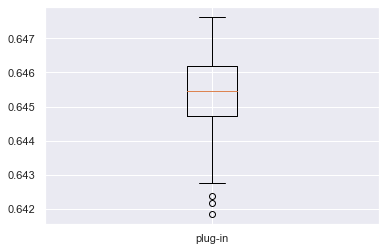

In [236]:
plt.boxplot(mat_err[:,0])
plt.xticks([1], ['plug-in'])
plt.show()

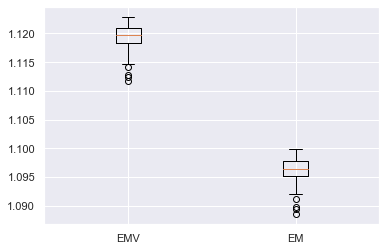

In [232]:
plt.boxplot(mat_err[:,1:3])
plt.xticks([1, 2], ['EMV','EM'])
plt.show()

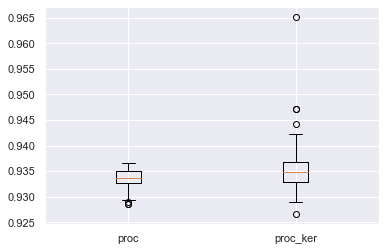

In [230]:
plt.boxplot(mat_err[:,3:])
plt.xticks([1,2], ['proc','proc_ker'])
plt.show()

# Calage sur marge

On fait des calages sur marge selon des critères Socio-démographiques et sur le nombre de visites sur les 100 brands du top100 pour chacune des bases de données. On obtient ainsi de nouveaux poids pour chaque panéliste de chacune des bases.

L'idée ici est donc de reproduire avec cvxpy la méthode de calge proposée par l'INSEE


In [48]:
d1,d2,n1,n2,n3 =  3,3,500,500,500
d=d1+d2
n=n1+n2+n3
A_star=generate_A_star_poisson(d,n,10)

np.random.seed(1234)
marges= np.sum(PA_star,axis=0)+600 #pour ne pas partir trop loin de ce qu'on a 
#print(marges, np.sum(PA_star,axis=0))
weights=np.repeat(1,len(PA_star)) # poids initiaux à 1 pour le moment
PA_star.shape

(1500, 6)

In [49]:
print("start")
lambd= cp.Variable(d1+d2)

function=0
for j in range(d1+d2):
    if j%20==0:
        print(j)
    sum_indiv=0
    for i,xi in enumerate(PA_star):
        sum_indiv+=weights[i]*(1+cp.sum(lambd*xi))*xi[j] #F(u)=1+u linéaire
    function+=cp.square(sum_indiv-marges[j])
    
# Construct the problem.
print("objective")
objective = cp.Minimize(function)
#constraints = [0 <= lambd, lambd <= 1]
constraints=[]
print("problem")
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
print("solving")
result = prob.solve(verbose=1)
# The optimal value for lambd is stored in `lambd.value`.
print(lambd.value)



start
0
objective
problem
solving
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 12, constraints m = 6
          nnz(P) + nnz(A) = 48
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   6.00e+02   3.07e+05   1.00e-01   5.92e-04s
  50   2.7147e-26   1.08e-06   4.14e-06   1.00e-01   6.55e-04s
plsh   1.1392e-

[ 7.27595761e-12  2.36468622e-11 -5.45696821e-12  1.81898940e-12
  1.63709046e-11  1.81898940e-11]


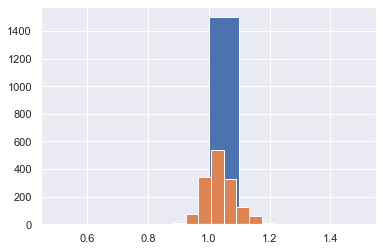

In [52]:
#nouveaux poids
new_weights=np.zeros(len(PA_star))
for i,ligne in enumerate(PA_star):
    new_weights[i]=weights[i]*(1+np.dot(lambd.value,ligne))

plt.hist(weights)
plt.hist(new_weights)
marges_reconstruites=np.sum((PA_star.T*new_weights).T,axis=0)
print(marges-marges_reconstruites)

Les poids initiaux étaient de 1, on remarque que les poids ont été modifiés autour de leur valeur initiale, cette déformation permet le calage